In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
# load standard python modules

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn
from modules.jet_vars import nsub, convert_constits_coords, mj
from modules.utils import LRScheduler, EarlyStopping

seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = cuda.get_current_device()
device.reset()

plt.style.use("science.mplstyle")

from matplotlib.backends.backend_pdf import PdfPages


torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)


device: cuda


# Sanity check 1: can we realize the SOTA maxSIC with a FCN trained on the 4 classic jet observables?

In [ ]:
# Load in the full dataset

path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
samp_id = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_data = path_to_save_dir+samp_id
print(path_to_data)
path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


data_train = np.load(path_to_data+"data_train.npy")
labels_train = np.load(path_to_data+"labels_train.npy")
data_val = np.load(path_to_data+"data_val.npy")
labels_val = np.load(path_to_data+"labels_val.npy")
STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")


# Crop the data, rescale pt
cropped_data_train = remove_jet_and_rescale_pT(data_train, n_jets)
cropped_data_val = remove_jet_and_rescale_pT(data_val, n_jets)
cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Data train shape: " + str( cropped_data_train.shape ), flush=True)
print( "Labels train shape: " + str( labels_train.shape ), flush=True)
print( "Data val shape: " + str( cropped_data_val.shape ), flush=True)
print( "Labels val shape: " + str( labels_val.shape ), flush=True)

print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)


# Split the events into the hardest and second jets

data_train_hardest = np.split(cropped_data_train, 2, axis = 2)[0]
data_train_second = np.split(cropped_data_train, 2, axis = 2)[1]
data_val_hardest = np.split(cropped_data_val, 2, axis = 2)[0]
data_val_second = np.split(cropped_data_val, 2, axis = 2)[1]
data_STS_hardest = np.split(cropped_STS_data, 2, axis = 2)[0]
data_STS_second = np.split(cropped_STS_data, 2, axis = 2)[1]

print( "Data train shape, hardest jet: " + str( data_train_hardest.shape ), flush=True)
print( "Data train shape, second jet: " + str( data_train_second.shape ), flush=True)




In [ ]:
# Calculate the jet params t21, mass

def t21(jets):

    """
    Events is an array of size (# jets, 3,2 x # constituents)where the 1-index goes through (pT, eta, phi)
    """
    
    # convert the pT, eta, phi coords to E, px py, px
    jets_cartesian = convert_constits_coords(jets)
    
    # calculate the n_jettiness
    taus = nsub(jets_cartesian)
    
    taus_21 = taus[:,0]
    taus_32 = taus[:,1]
    
    return taus_21


print("Calculating jet observables...")

print("Calculating mj hardest jet...")
mj_hardest_train = mj(data_train_hardest)
mj_hardest_val = mj(data_val_hardest)
mj_hardest_test = mj(data_STS_hardest)
print("Calculating mj second jet...")
mj_second_train = mj(data_train_second)
mj_second_val = mj(data_val_second)
mj_second_test = mj(data_STS_second)

print("Calculating t21 hardest jet...")
t21_hardest_train = t21(data_train_hardest)
t21_hardest_val = t21(data_val_hardest)
t21_hardest_test = t21(data_STS_hardest)
print("Calculating t21 second jet...")
t21_second_train = t21(data_train_second)
t21_second_val = t21(data_val_second)
t21_second_test = t21(data_STS_second)

print("Done!")


In [ ]:
# Visualise the jet observables 

t21_bins = np.linspace(0,1,20)
mj_bins = np.linspace(0,3,20)

plt.figure()
plt.hist(t21_hardest_train, bins = t21_bins, label = "hardest", alpha = 0.3)
plt.hist(t21_second_train, bins = t21_bins, label = "second", alpha = 0.3)
plt.xlabel("t21")
plt.legend()
plt.show()

plt.figure()
plt.hist(mj_hardest_train, bins = mj_bins, label = "hardest", alpha = 0.3)
plt.hist(mj_second_train, bins = mj_bins, label = "second", alpha = 0.3)
plt.xlabel("mj")
plt.legend()
plt.show()

In [ ]:
# Assemble the arrays for training the FCN

# train
t21_hardest_train = np.reshape(t21_hardest_train,(t21_hardest_train.shape[0],1))
t21_second_train = np.reshape(t21_second_train,(t21_second_train.shape[0],1))
mj_hardest_train = np.reshape(mj_hardest_train,(mj_hardest_train.shape[0],1))
mj_second_train = np.reshape(mj_second_train,(mj_second_train.shape[0],1))
all_data_train = np.concatenate((t21_hardest_train,t21_second_train,mj_hardest_train,mj_second_train), axis = 1)

# val
t21_hardest_val = np.reshape(t21_hardest_val,(t21_hardest_val.shape[0],1))
t21_second_val = np.reshape(t21_second_val,(t21_second_val.shape[0],1))
mj_hardest_val = np.reshape(mj_hardest_val,(mj_hardest_val.shape[0],1))
mj_second_val = np.reshape(mj_second_val,(mj_second_val.shape[0],1))
all_data_val = np.concatenate((t21_hardest_val,t21_second_val,mj_hardest_val,mj_second_val), axis = 1)

# test
t21_hardest_test = np.reshape(t21_hardest_test,(t21_hardest_test.shape[0],1))
t21_second_test = np.reshape(t21_second_test,(t21_second_test.shape[0],1))
mj_hardest_test = np.reshape(mj_hardest_test,(mj_hardest_test.shape[0],1))
mj_second_test = np.reshape(mj_second_test,(mj_second_test.shape[0],1))
all_data_test = np.concatenate((t21_hardest_test,t21_second_test,mj_hardest_test,mj_second_test), axis = 1)

print("Training set shape:", all_data_train.shape)
print("Validation set shape:", all_data_val.shape)
print("Testing set shape:", all_data_test.shape)

In [ ]:
# Run the dense NN

input_shape = 4
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              all_data_train, labels_train, 
                              all_data_val, labels_val,
                              all_data_test, STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

In [ ]:
# Plot

print(performance_stats["auc"])

plt.figure()
plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure()
plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()

SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
plt.figure()
plt.plot(performance_stats["tpr"], SIC)
#plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("SIC")
plt.show()


# Sanity check 2: how data-hungry is the transBC?

In [ ]:
# Cell 1/3 for batch .py script

data_frac = 1
expt_dir = "sanity_checks/"
model_dim  = 128


path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
BC_dir = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2

path_to_BC = path_to_save_dir+BC_dir
print(path_to_BC)
path_to_test = path_to_save_dir+TEST_dir
print(path_to_test)


data_train = np.load(path_to_BC+"data_train.npy")
labels_train = np.load(path_to_BC+"labels_train.npy")
data_val = np.load(path_to_BC+"data_val.npy")
labels_val = np.load(path_to_BC+"labels_val.npy")
data_test_f = np.load(path_to_test+"data.npy")
labels_test_f = np.load(path_to_test+"labels.npy")

data_train = remove_jet_and_rescale_pT(data_train, n_jets)[:int(data_frac*data_train.shape[0])]
data_val = remove_jet_and_rescale_pT(data_val, n_jets)[:int(data_frac*data_val.shape[0])]
data_test_f = remove_jet_and_rescale_pT(data_test_f, n_jets)[:int(data_frac*data_test_f.shape[0])]

labels_train = labels_train[:int(data_train.shape[0])]
labels_val = labels_val[:int(data_val.shape[0])]
labels_test_f = labels_test_f[:int(data_test_f.shape[0])]

# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


In [ ]:
# Cell 2/3 for batch .py script


# transformer hyperparams
input_dim = 3
output_dim = model_dim
dim_feedforward = model_dim
n_heads = 4
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.00001
batch_size = 400

netBC = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt, BC = True )

## send network to device
netBC.to( device )


In [ ]:
# Cell 3/3 for batch .py script


# define lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( netBC.optimizer, factor=0.2 )

run_BC_transformer = False

criterion = nn.BCELoss()

early_stop = True
if early_stop:
    early_stopping = EarlyStopping()
    
if run_BC_transformer:

    # THE TRAINING LOOP

    # initialise lists for storing training stats, validation loss
    losses_BC_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    loss_validation_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss

    n_epochs = 5000
    loss_check_epoch = 10
    verbal_epoch = 10

    for constit_num in range(grading,n_constits_max+grading,grading):

        t0 = time.time()

        print( "starting training loop, running for " + str( n_epochs ) + " epochs" + " with " + str(constit_num) + " constituents" 
              , flush=True)
        print("BC training data shape:",data_train.shape)
        print("BC val data shape:",data_val.shape)
        print( "---", flush=True )

        # re-batch the data on each epoch
        for epoch in range( n_epochs + 1 ):

            # get batch_size number of indices
            indices_list = torch.split( torch.randperm( data_train.shape[0] ), batch_size )

            # initialise lists to store batch stats
            losses_BC_e = []

            # the inner loop goes through the dataset batch by batch
            # augmentations of the jets are done on the fly
            for i, indices in enumerate( indices_list ): # random jets from the dataset
                netBC.optimizer.zero_grad()
                """
                DATA PREPARATION
                """
                x_i = data_train[indices,:,:]
                labels_i = labels_train[indices]

                x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                labels_i = torch.Tensor( labels_i ).to( device )
                z_i = netBC( x_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)

                """
                LOSS CALCULATIONS
                """           

                # compute the loss based on predictions of the netBC and the correct answers
                loss = criterion( z_i, labels_i.reshape(-1,1)).to( device )
                loss.backward()
                netBC.optimizer.step()
                netBC.optimizer.zero_grad()
                
                losses_BC_e.append( loss.detach().cpu().numpy() )
                
            """
            AVERAGING OF LOSSES
            """ 
            loss_BC_e = np.mean( np.array( losses_BC_e ) )
            ## scheduler
            scheduler.step( loss_BC_e )

            # storage
            losses_BC_num_jets[constit_num].append( loss_BC_e )
           
            """
            EVERY SO OFTEN, GIVEN AN UPDATE
            """

            if epoch % verbal_epoch == 0:

                print( "epoch: " + str( epoch ) + ", loss: " + str( round(losses_BC_num_jets[constit_num][-1], 5) ), flush=True )
                print("time taken up to now: " + str(time.time()-t0))
                print()

            if epoch % loss_check_epoch == 0:

                """
                Get the validation loss
                """
                print("Getting the validation loss...")
                # store the epoch
                loss_validation_num_jets[constit_num][0].append(epoch)

                with torch.no_grad():
                    netBC.eval()

                    # get batch_size number of indices
                    indices_list_val = torch.split( torch.randperm( data_val.shape[0] ), batch_size )
                    local_val_losses = []

                    for j, indices_val in enumerate( indices_list_val ):
                        
                        """
                        DATA PREPARATION
                        """
                        a_i = data_val[indices_val,:,:]
                        labelsa_i = labels_val[indices_val]

                        a_i = torch.Tensor( a_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                        labelsa_i = torch.Tensor( labelsa_i ).to( device )
                        w_i = netBC( a_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)

                        """
                        LOSS CALCULATIONS
                        """           

                        # compute the loss based on predictions of the netBC and the correct answers
                        loss_val = criterion( w_i, labelsa_i.reshape(-1,1)).to( device )
                        local_val_losses.append(loss_val.detach().cpu().numpy())
                
                    loss_val_e = np.mean( np.array( local_val_losses ) )
                    loss_validation_num_jets[constit_num][1].append(loss_val_e)
                  
                    if early_stop:
                        early_stopping(loss_val_e)
            
            if early_stopping.early_stop:
                break

        t1 = time.time()

        print( "BC TRAINING DONE, time taken: " + str( np.round( t1-t0, 2 ) ), flush=True)


        # save out results
        print( "saving out data/results", flush=True)
        np.save( expt_dir+"BC_losses_train_"+str(data_frac)+".npy", losses_BC_num_jets[constit_num] )
        np.save( expt_dir+"BC_losses_val_"+str(data_frac)+".npy", loss_validation_num_jets[constit_num] )

        # save out final trained model
        print( "saving out final BC model", flush=True )
        torch.save(netBC.state_dict(), expt_dir+"final_model_BC_"+str(data_frac)+".pt")
        print()
        



In [ ]:
# Loading in the final transformer and plotting

data_fracs = [0.25, .5, .75, 1]
fpr_dict_transBC = {}
tpr_dict_transBC = {}


for data_frac in data_fracs:


    loaded_net_BC = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                      n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt, BC = True )

    loaded_net_BC.load_state_dict(torch.load(expt_dir+"final_model_BC_"+str(data_frac)+".pt"))
    loaded_net_BC.eval()

    loaded_net_BC.to( device )

    print("Evaluating...")
    
    with torch.no_grad():    

        inputs = torch.Tensor( data_test_f ).transpose(1,2).to( device )

        outputs = loaded_net_BC( inputs, use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
        predicted = np.round(outputs).reshape(labels_test_f.size)

        # calculate auc 
        auc = roc_auc_score(labels_test_f, outputs)

        fpr, tpr, _ = roc_curve(labels_test_f, outputs)

        total = labels_test_f.size
        correct = (predicted == labels_test_f).sum()   
        
        fpr_dict_transBC[data_frac] = fpr
        tpr_dict_transBC[data_frac] = tpr

      

In [ ]:
from sklearn import metrics

gap = 4

from matplotlib.pyplot import cm
color = iter(cm.Reds(np.linspace(0, 1, 4+gap)))
for i in range(gap):
    c = next(color)
    
l = 3
title_fontsize = 18

labels_dict = {0.25:"25%", 0.5:"50%", 0.75:"75%", 1:"100%"}

fig = plt.figure(figsize = (15,12))
for data_frac in data_fracs:
    c = next(color)
    print("Fraction of total LHCO Events:", data_frac,"; ROC AUC:", metrics.auc(fpr_dict_transBC[data_frac], tpr_dict_transBC[data_frac]))
    plt.plot(tpr_dict_transBC[data_frac], 1.0/fpr_dict_transBC[data_frac], label = labels_dict[data_frac], color = c, linewidth = l)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")


ax = plt.gca()

# legend fun
handles, labels = plt.gca().get_legend_handles_labels()
handles_sb = handles[:-1]
labels_sb = labels[:-1]

plt.rcParams['legend.title_fontsize'] = title_fontsize
leg1 = plt.legend(handles=handles, labels=labels, 
                  title="Percentage of full training dataset", bbox_to_anchor=(0.92, 0.91), 
                  ncol=1
                  , handlelength=1.6, handletextpad=0.4, loc="upper right",
                  frameon=False, borderaxespad=0)
ax.add_artist(leg1)




plt.show()


img_name = "figures/trans_BC_data_fraction.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()



# Sanity check 3: how data-hungry is the FCN?

In [2]:

expt_dir = "sanity_checks/"
path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
BC_dir = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2

path_to_BC = path_to_save_dir+BC_dir
print(path_to_BC)

path_to_test = path_to_save_dir+TEST_dir
print(path_to_test)


data_train = np.load(path_to_BC+"data_train.npy")
labels_train = np.load(path_to_BC+"labels_train.npy")
data_val = np.load(path_to_BC+"data_val.npy")
labels_val = np.load(path_to_BC+"labels_val.npy")
data_test_f = np.load(path_to_test+"data.npy")
labels_test_f = np.load(path_to_test+"labels.npy")

data_train = remove_jet_and_rescale_pT(data_train, n_jets)
data_val = remove_jet_and_rescale_pT(data_val, n_jets)
data_test_f = remove_jet_and_rescale_pT(data_test_f, n_jets)

labels_train = labels_train
labels_val = labels_val
labels_test_f = labels_test_f


data_train = np.reshape(data_train,(data_train.shape[0],300))
data_val = np.reshape(data_val,(data_val.shape[0],300))
data_test_f = np.reshape(data_test_f,(data_test_f.shape[0],300))

# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


/global/home/users/rrmastandrea/training_data_vf/nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data_vf/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
BC training data shape: (119000, 300)
BC training labels shape: (119000,)
BC val data shape: (51000, 300)
BC val labels shape: (51000,)
BC test data shape: (20000, 300)
BC test labels shape: (20000,)


In [5]:

num_epochs_nn = 1200
batch_size_nn = 400
update_epochs_nn = 10
input_shape = 300
lr_nn = 0.0001

data_fracs = [0.25, .5, .75, 1]

for data_frac in data_fracs:
    
    print("On data fraction", data_frac)
    
    loc_data_train = data_train[:int(data_frac*data_train.shape[0])]
    loc_data_val = data_val[:int(data_frac*data_val.shape[0])]
    loc_data_test_f = data_test_f[:int(data_frac*data_test_f.shape[0])]

    loc_labels_train = labels_train[:int(loc_data_train.shape[0])]
    loc_labels_val = labels_val[:int(loc_data_val.shape[0])]
    loc_labels_test_f = labels_test_f[:int(loc_data_test_f.shape[0])]
    
    print( "BC training data shape: " + str( loc_data_train.shape ), flush=True)
    print( "BC val data shape: " + str( loc_data_val.shape ), flush=True)
    print( "BC test data shape: " + str( loc_data_test_f.shape ), flush=True)
    

    performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                             loc_data_train, loc_labels_train, 
                          loc_data_val, loc_labels_val,
                          loc_data_test_f, loc_labels_test_f, True)
    
    
    np.save(expt_dir+"SC3_FCN_"+str(data_frac)+"_fpr", performance_stats_nn["fpr"])
    np.save(expt_dir+"SC3_FCN_"+str(data_frac)+"_tpr", performance_stats_nn["tpr"])
  


On data fraction 0.25
BC training data shape: (29750, 300)
BC val data shape: (12750, 300)
BC test data shape: (5000, 300)
Starting training...


 21%|██        | 250/1200 [00:37<02:23,  6.64it/s]

INFO: Early stopping
Finished Training
On data fraction 0.5
BC training data shape: (59500, 300)
BC val data shape: (25500, 300)
BC test data shape: (10000, 300)


Starting training...


 28%|██▊       | 340/1200 [01:39<04:12,  3.41it/s]

INFO: Early stopping
Finished Training
On data fraction 0.75
BC training data shape: (89250, 300)
BC val data shape: (38250, 300)
BC test data shape: (15000, 300)


Starting training...


 42%|████▏     | 500/1200 [03:29<04:52,  2.39it/s]

INFO: Early stopping
Finished Training
On data fraction 1
BC training data shape: (119000, 300)
BC val data shape: (51000, 300)
BC test data shape: (20000, 300)


Starting training...


 29%|██▉       | 350/1200 [03:20<08:06,  1.75it/s]

INFO: Early stopping
Finished Training


Fraction of total LHCO Events: 0.25 ; ROC AUC: 0.9271490558517639
Fraction of total LHCO Events: 0.5 ; ROC AUC: 0.9448017446731165
Fraction of total LHCO Events: 0.75 ; ROC AUC: 0.9561313440921261
Fraction of total LHCO Events: 1 ; ROC AUC: 0.958362905


/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide


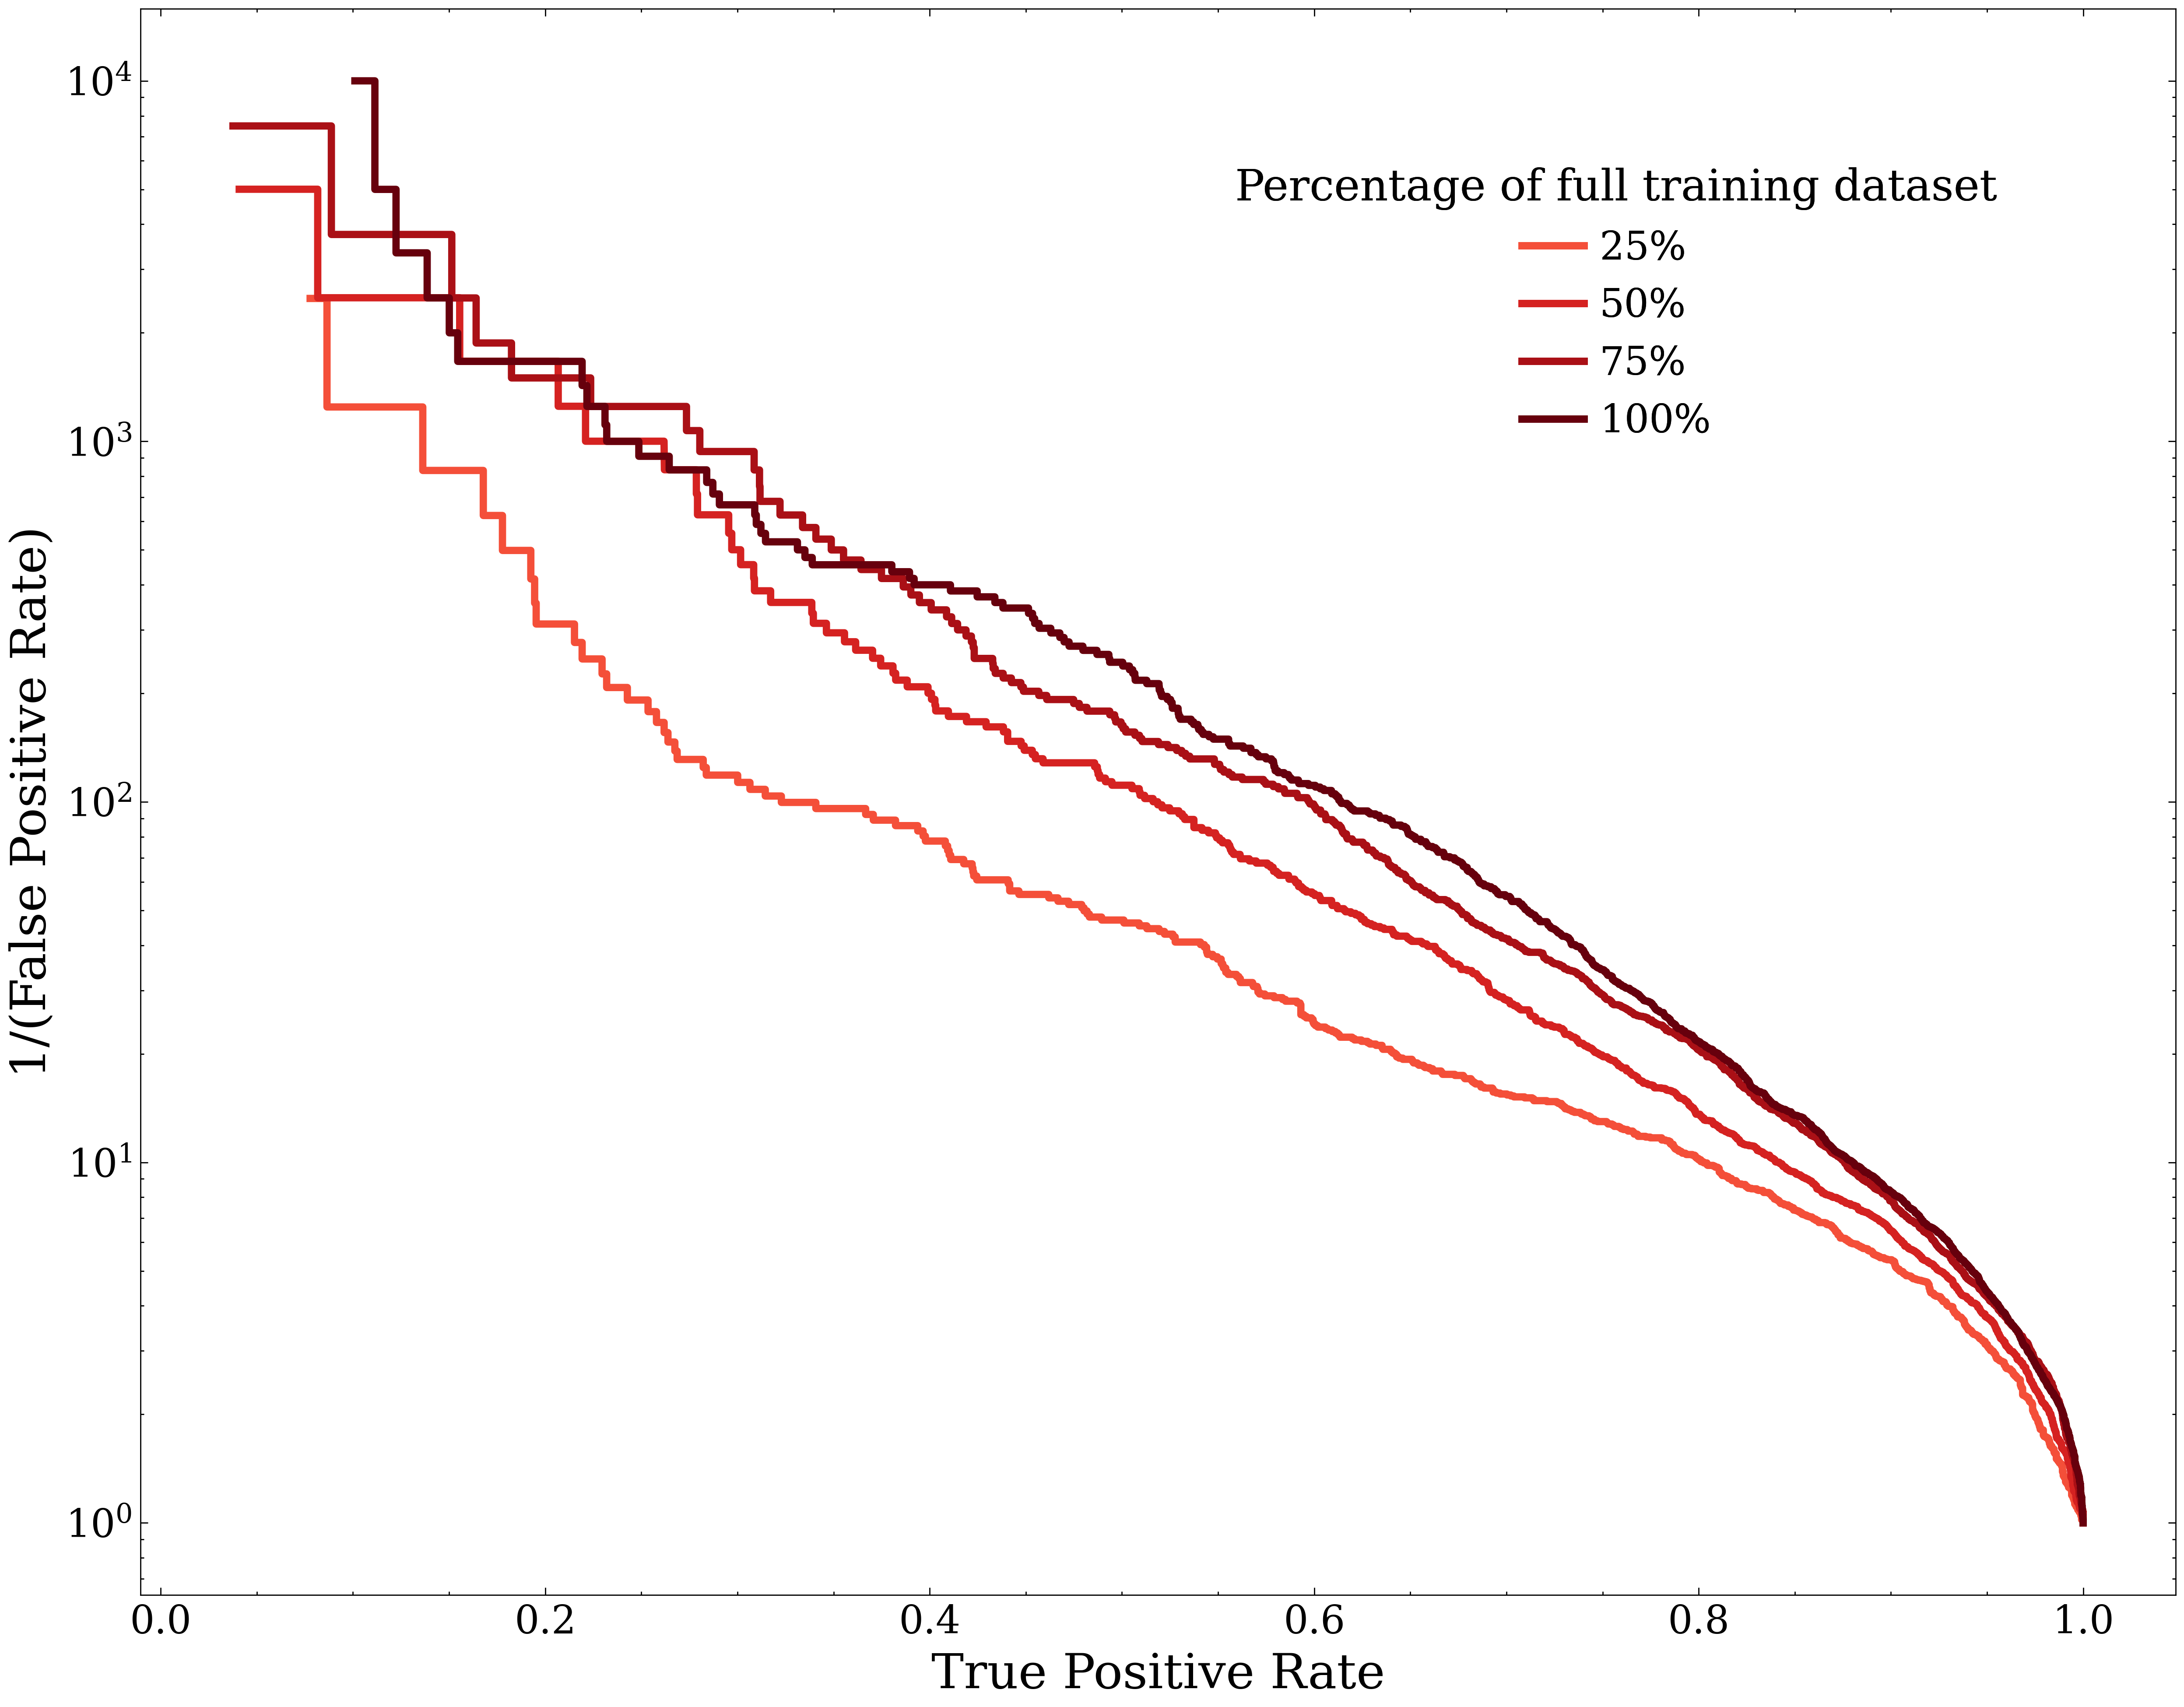

In [7]:

fpr_dict_FCN = {}
tpr_dict_FCN = {}


for data_frac in data_fracs:
    fpr_dict_FCN[data_frac] = np.load(expt_dir+"SC3_FCN_"+str(data_frac)+"_fpr.npy")
    tpr_dict_FCN[data_frac] = np.load(expt_dir+"SC3_FCN_"+str(data_frac)+"_tpr.npy")

    
gap = 4
from sklearn import metrics


from matplotlib.pyplot import cm
color = iter(cm.Reds(np.linspace(0, 1, 4+gap)))
for i in range(gap):
    c = next(color)
    
l = 3
title_fontsize = 18

labels_dict = {0.25:"25%", 0.5:"50%", 0.75:"75%", 1:"100%"}

fig = plt.figure(figsize = (15,12))
for data_frac in data_fracs:
    c = next(color)
    print("Fraction of total LHCO Events:", data_frac,"; ROC AUC:", metrics.auc(fpr_dict_FCN[data_frac], tpr_dict_FCN[data_frac]))
    plt.plot(tpr_dict_FCN[data_frac], 1.0/fpr_dict_FCN[data_frac], label = labels_dict[data_frac], color = c, linewidth = l)
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")


ax = plt.gca()

# legend fun
handles, labels = plt.gca().get_legend_handles_labels()
handles_sb = handles[:-1]
labels_sb = labels[:-1]

plt.rcParams['legend.title_fontsize'] = title_fontsize
leg1 = plt.legend(handles=handles, labels=labels, 
                  title="Percentage of full training dataset", bbox_to_anchor=(0.92, 0.91), 
                  ncol=1
                  , handlelength=1.6, handletextpad=0.4, loc="upper right",
                  frameon=False, borderaxespad=0)
ax.add_artist(leg1)




plt.show()



img_name = "figures/FCN_data_fraction.pdf"
pp = PdfPages(img_name)
pp.savefig(fig)
pp.close()



# Sanity check 4: what happens when we train a FCN on jets + their augmented versions?

In [ ]:
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets, remove_jet_and_rescale_pT
from modules.jet_augs import shift_eta, shift_phi
from modules.jet_visualizers import plot_jets_phase_plane

In [ ]:
# create sample of jets

path_to_save_dir = "/global/home/users/rrmastandrea/training_data_vf/"
BC_dir = "nBC_sig_85000_nBC_bkg_85000_n_nonzero_50_n_pad_0_n_jet_2/"
TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2

path_to_BC = path_to_save_dir+BC_dir
print(path_to_BC)

path_to_test = path_to_save_dir+TEST_dir
print(path_to_test)


data_train = np.load(path_to_BC+"data_train.npy")
labels_train = np.load(path_to_BC+"labels_train.npy")
data_val = np.load(path_to_BC+"data_val.npy")
labels_val = np.load(path_to_BC+"labels_val.npy")
data_test_f = np.load(path_to_test+"data.npy")
labels_test_f = np.load(path_to_test+"labels.npy")

labels_train = labels_train
labels_val = labels_val
labels_test_f = labels_test_f


# print data dimensions
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


In [ ]:
# create sample of augmented jets

# augmentations
rot = True # rotations
trs = False # translations
dis = True # distortion
col = True # collinear

center = "J1_phi_only_pi_2"

print("Augmenting the data...")

# train
x_i, x_j = apply_single_jet_augs(data_train, 2, center, rot, trs, dis, col)
x_j = shift_eta(shift_phi(x_j))
# rescaling pT
max_pt = np.max(x_i[:,0,:])
pt_rescale_denom  = max_pt/ 10.
data_train = rescale_pts( x_i, pt_rescale_denom )
data_train_augmented = rescale_pts( x_j, pt_rescale_denom )
                                                       

# val
x_i, x_j = apply_single_jet_augs(data_val, 2, center, rot, trs, dis, col)
x_j = shift_eta(shift_phi(x_j))
# rescaling pT
max_pt = np.max(x_i[:,0,:])
pt_rescale_denom  = max_pt/ 10.
data_val = rescale_pts( x_i, pt_rescale_denom )
data_val_augmented = rescale_pts( x_j, pt_rescale_denom )

# test
x_i, x_j = apply_single_jet_augs(data_test_f, 2, center, rot, trs, dis, col)
x_j = shift_eta(shift_phi(x_j))
# rescaling pT
max_pt = np.max(x_i[:,0,:])
pt_rescale_denom  = max_pt/ 10.
data_test_f = rescale_pts( x_i, pt_rescale_denom )
data_test_f_augmented = rescale_pts( x_j, pt_rescale_denom )


print(data_train.shape)
print(data_train_augmented.shape)
print(data_val.shape)
print(data_val_augmented.shape)
print(data_test_f.shape)
print(data_test_f_augmented.shape)


print("Done!")

In [ ]:

for i in range(5):
    
    plot_jets_phase_plane(data_train[i], data_train_augmented[i], 20, xlims=(-3,3), ylims=(-3,3))


In [ ]:

# Flatten the data

data_train = np.reshape(data_train,(data_train.shape[0],300))
data_val = np.reshape(data_val,(data_val.shape[0],300))
data_test_f = np.reshape(data_test_f,(data_test_f.shape[0],300))

data_train_augmented = np.reshape(data_train_augmented,(data_train_augmented.shape[0],300))
data_val_augmented = np.reshape(data_val_augmented,(data_val_augmented.shape[0],300))
data_test_f_augmented = np.reshape(data_test_f_augmented,(data_test_f_augmented.shape[0],300))

print(data_train.shape)
print(data_train_augmented.shape)
print(data_val.shape)
print(data_val_augmented.shape)
print(data_test_f.shape)
print(data_test_f_augmented.shape)
print()
print()
 
# Combine samples of reg vs aug jets

def amass_jets(frac_orig, frac_mod):
    
    num_orig_data = int(frac_orig*data_train.shape[0])
    num_mod_data = int(frac_mod*data_train_augmented.shape[0])
    
    num_orig_val = int(frac_orig*data_val.shape[0])
    num_mod_val = int(frac_mod*data_val_augmented.shape[0])
    
  
    
    # train 
    local_train_orig_data = data_train[:num_orig_data]
    local_train_mod_data = data_train_augmented[(data_train.shape[0]-num_mod_data):]
    local_train_orig_labels = labels_train[:num_orig_data]
    local_train_mod_labels = labels_train[(data_train.shape[0]-num_mod_data):]
    local_train_data = np.concatenate((local_train_orig_data,local_train_mod_data))
    local_train_labels = np.concatenate((local_train_orig_labels,local_train_mod_labels))
    
    # val
    local_val_orig_data = data_val[:num_orig_val]
    local_val_mod_data = data_val_augmented[(data_val.shape[0]-num_mod_val):]
    local_val_orig_labels = labels_val[:num_orig_val]
    local_val_mod_labels = labels_val[(data_val.shape[0]-num_mod_val):]
    local_val_data = np.concatenate((local_val_orig_data,local_val_mod_data))
    local_val_labels = np.concatenate((local_val_orig_labels,local_val_mod_labels))

    
    return local_train_data, local_train_labels, local_val_data, local_val_labels
    
  

In [ ]:
# train on original jets only


input_shape = 300
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001


local_train_data, local_train_labels, local_val_data, local_val_labels = amass_jets(1.0, 0)

print("Training data shape:", local_train_data.shape)
print("Validation data shape:", local_val_data.shape)


performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs,lr, 
                                             local_train_data, local_train_labels, 
                          local_val_data, local_val_labels,
                          data_test_f, labels_test_f, True)   


np.save(expt_dir+"SC4_original_only_fpr", performance_stats["fpr"])
np.save(expt_dir+"SC4_original_only_tpr", performance_stats["tpr"])




In [ ]:
# train on original + augmented jets


input_shape = 300
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001


local_train_data, local_train_labels, local_val_data, local_val_labels = amass_jets(1.0, 1.0)

print("Training data shape:", local_train_data.shape)
print("Validation data shape:", local_val_data.shape)


performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs,lr, 
                                             local_train_data, local_train_labels, 
                          local_val_data, local_val_labels,
                          data_test_f, labels_test_f, True)   


np.save(expt_dir+"SC4_original_and_augmented_fpr", performance_stats["fpr"])
np.save(expt_dir+"SC4_original_and_augmented_tpr", performance_stats["tpr"])


In [ ]:
tpr_orig_only = np.load(expt_dir+"SC4_original_only_tpr.npy")
fpr_orig_only = np.load(expt_dir+"SC4_original_only_fpr.npy")

tpr_orig_and_aug = np.load(expt_dir+"SC4_original_and_augmented_tpr.npy")
fpr_orig_and_aug = np.load(expt_dir+"SC4_original_and_augmented_fpr.npy")



from sklearn import metrics




plt.figure(figsize = (10,10))


plt.plot(tpr_orig_only, 1.0/fpr_orig_only, label = "orig", color = "green")
plt.plot(tpr_orig_and_aug, 1.0/fpr_orig_and_aug, label = "orig+aug", color = "blue")

    
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.legend()
plt.title("Aug frac for training")
plt.show()



print("orig ROC AUC:", metrics.auc(fpr_orig_only, tpr_orig_only))
print("orig+mod ROC AUC:", metrics.auc(fpr_orig_and_aug, tpr_orig_and_aug))



